# Quote Generator using LSTM

In [173]:
# Setting up Kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [2]:
# Downloading Dataset from kaggle

!kaggle datasets download -d manann/quotes-500k

 93% 83.0M/89.6M [00:02<00:00, 54.1MB/s]
100% 89.6M/89.6M [00:02<00:00, 42.4MB/s]


In [1]:
# Unzipping Dataset

import zipfile
f = zipfile.ZipFile("/content/quotes-500k.zip", "r")
f.extractall("/content")
f.close()

In [39]:
# Basic Imports

import pandas as pd
import numpy as np
import tensorflow as tf

In [40]:
# Load Dataset

df = pd.read_csv("/content/quotes.csv")
df.shape

(499709, 3)

### Dataset Overview
We are only interested in Quote column.

In [41]:
df

,quote,author,category
0,"I'm selfish, impatient and a little insecure. ...",Marilyn Monroe,"attributed-no-source, best, life, love, mistak..."
1,You've gotta dance like there's nobody watchin...,William W. Purkey,"dance, heaven, hurt, inspirational, life, love..."
2,You know you're in love when you can't fall as...,Dr. Seuss,"attributed-no-source, dreams, love, reality, s..."
3,A friend is someone who knows all about you an...,Elbert Hubbard,"friend, friendship, knowledge, love"
4,Darkness cannot drive out darkness: only light...,"Martin Luther King Jr., A Testament of Hope: T...","darkness, drive-out, hate, inspirational, ligh..."
...,...,...,...
499704,I do believe the most important thing I can do...,John C. Stennis,"Past, Believe, Help"
499705,I'd say I'm a bit antimadridista although I do...,Isco,"Team, Humility, Know"
499706,The future is now.,Nam June Paik,Now
499707,"In all my life and in the future, I will alway...",Norodom Sihamoni,"Life, My Life, Servant"


Out of around 500k quotes I am using only 1000 quotes

In [42]:
df = df.iloc[:1000,:]

In [43]:
# Filtering out quotes who has small length

def filter(x):
  try:
    if len(x) < 500:
      return True
    else:
      return False
  except:
    return False

f = df['quote'].apply(filter)

In [44]:
df = df[f]

In [45]:
df = df["quote"]

Creating list of quotes for tokenization

In [46]:
text = df.to_list()

In [47]:
text[:2]

["I'm selfish, impatient and a little insecure. I make mistakes, I am out of control and at times hard to handle. But if you can't handle me at my worst, then you sure as hell don't deserve me at my best.",
 "You've gotta dance like there's nobody watching,Love like you'll never be hurt,Sing like there's nobody listening,And live like it's heaven on earth."]

### Text Preprocessing

In [48]:
import string

def clean_text(ls):
  clean_ls = []
  for line in ls:
    try:
      tokens = line.split()
      table = str.maketrans('', '', string.punctuation)
      tokens = [w.translate(table) for w in tokens]
      tokens = [word for word in tokens if word.isalpha()]
      tokens = [word.lower() for word in tokens]
      clean_ls.append(tokens)
    except:
      print(ls)
  return clean_ls

In [49]:
text = clean_text(text)

Creating string from all quotes to train tokenizer, <br>
Specifically interger tokenization.

In [51]:
string_text = " ".join([x for i in text for x in i])

In [52]:
string_text[:100]

'im selfish impatient and a little insecure i make mistakes i am out of control and at times hard to '

### Tokenization

In [53]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [54]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([string_text])

In [55]:
# Finding total unique words

len(tokenizer.word_index)

3420

### Input Sequencing

I am trying to create sequence where we'll predict a word based on previous word or sentence.

In [57]:
input_sequences = []
for sentence in text:
  tokenized_sentence = tokenizer.texts_to_sequences([sentence])[0]
  for i in range(1,len(tokenized_sentence)):
    input_sequences.append(tokenized_sentence[:i+1])

In [58]:
# end input will be output

input_sequences[0]

[110, 714]

Cross cheacking tokenizatin with sequencing

In [59]:
string_text[:10]

'im selfish'

In [60]:
print(tokenizer.word_index["im"], tokenizer.word_index["selfish"])

110 714


In [61]:
input_sequences[:15]

[[110, 714],
 [110, 714, 1360],
 [110, 714, 1360, 5],
 [110, 714, 1360, 5, 7],
 [110, 714, 1360, 5, 7, 146],
 [110, 714, 1360, 5, 7, 146, 894],
 [110, 714, 1360, 5, 7, 146, 894, 4],
 [110, 714, 1360, 5, 7, 146, 894, 4, 74],
 [110, 714, 1360, 5, 7, 146, 894, 4, 74, 715],
 [110, 714, 1360, 5, 7, 146, 894, 4, 74, 715, 4],
 [110, 714, 1360, 5, 7, 146, 894, 4, 74, 715, 4, 97],
 [110, 714, 1360, 5, 7, 146, 894, 4, 74, 715, 4, 97, 98],
 [110, 714, 1360, 5, 7, 146, 894, 4, 74, 715, 4, 97, 98, 9],
 [110, 714, 1360, 5, 7, 146, 894, 4, 74, 715, 4, 97, 98, 9, 391],
 [110, 714, 1360, 5, 7, 146, 894, 4, 74, 715, 4, 97, 98, 9, 391, 5]]

In [62]:
# finding max length of input sequence, to determine the timesteps in LSTM
max_len = max([len(x) for x in input_sequences])

In [63]:
max_len

99

### Padding

I am using pre padding because keeping end timesteps non sparse gives better results.

In [64]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_input_sequences = pad_sequences(input_sequences, maxlen = max_len, padding='pre')

In [65]:
padded_input_sequences[:10]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,  110,  714],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,

### X Train and y Train

basically out output is end word of the sequence

In [66]:
X = padded_input_sequences[:,:-1]

In [67]:
y = padded_input_sequences[:,-1]

In [68]:
X.shape

(24286, 98)

In [69]:
y.shape

(24286,)

In [70]:
# Deleting some ram consumming variables
del input_sequences, padded_input_sequences

### Output preprocessing

Converting output into 3421 categories using OHE.
3421 categories defines

In [71]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y,num_classes=3421)

In [72]:
y.shape

(24286, 3421)

## Model Architecture

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [157]:
model = Sequential()
model.add(Embedding(3421, 100, input_length=98))
model.add(LSTM(300, return_sequences=True))
model.add(LSTM(300, return_sequences=True))
model.add(LSTM(300))
model.add(Dense(3421, activation='softmax'))

In [158]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [159]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 98, 100)           342100    
                                                                 
 lstm_5 (LSTM)               (None, 98, 300)           481200    
                                                                 
 lstm_6 (LSTM)               (None, 98, 300)           721200    
                                                                 
 lstm_7 (LSTM)               (None, 300)               721200    
                                                                 
 dense_3 (Dense)             (None, 3421)              1029721   
                                                                 
Total params: 3295421 (12.57 MB)
Trainable params: 3295421 (12.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


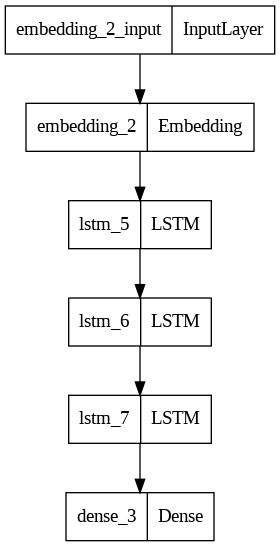

In [176]:
tf.keras.utils.plot_model(model)

In [161]:
model.fit(X,y,epochs=100)

Epoch 1/2
759/759 [==============================] - 21s 27ms/step - loss: 0.2388 - accuracy: 0.9306
Epoch 2/2
759/759 [==============================] - 21s 27ms/step - loss: 0.1284 - accuracy: 0.9612


## Quote Generator

In [162]:
def generator(seed, length = 15):
  for i in range(length):
    # tokenize
    token_text = tokenizer.texts_to_sequences([seed])[0]
    # padding
    padded_token_text = pad_sequences([token_text], maxlen=98, padding='pre')
    # predict
    pos = np.argmax(model.predict(padded_token_text, verbose=False))

    for word,index in tokenizer.word_index.items():
      if index == pos:
        seed = seed + " " + word
  return seed

## Examples

In [163]:
generator('man', 12)

'man may have discovered fire but women discovered how to play with it'

In [180]:
generator('the man', 17)

'the man of knowledge must be able not only to love his enemies but also to hate his friends'

In [164]:
generator('woman', 8)

'woman is sacred the woman one loves is holy'

In [165]:
generator('a friend', 10)

'a friend is someone who knows all about you and still loves'

In [166]:
generator('the world is', 14)

'the world is indeed full of peril and in it there are many dark places but still'

In [167]:
generator('world', 15)

'world is the voice under all silences the hope which has no opposite in fear the'

In [168]:
generator('the', 14)

'the only thing worse than a boy who hates you a boy that loves you'

In [169]:
generator('we can make', 15)

'we can make your life skipping the awful parts without losing what made it worthwhile you had to'

In [172]:
generator('wisdom', 13)

'wisdom marks a life even more deeply than love love risks degenerating into obsession'